# Post-Processing Notebook

In [1]:
#necessary imports
import data_utils as du
import numpy as np
import pandas as pd
import model_utils as mu
import joblib

In [2]:
#setting the standard root directory for the project
root_dir = 'data/tiles/processed/'

## Loading in the data and setting the necessary visual information

In [3]:
cmap, norm, legend_info = du.set_visuals()

In [4]:
species_map_path = 'S-SEDD_species_map.pkl'
distance_map_path = 'S-SEDD_distance_map.pkl'
probability_map_path = 'S_SEDD_probability.pkl'
original_image_path = 'S_SEDD_original.pkl'
species_ground_truth_path = 'S-SEDD_species_map_true.pkl'
distance_ground_truth_path = 'S-SEDD_distance_map_true.pkl'
maps_root_dir = 'pkl_files/'

In [5]:
species_pred = du.load_map(maps_root_dir + species_map_path)

In [6]:
distance_pred = du.load_map(maps_root_dir + distance_map_path)

In [7]:
probability_map = du.load_map(maps_root_dir + probability_map_path)

In [8]:
original_images = du.load_map(maps_root_dir + original_image_path)

In [9]:
species_true = du.load_map(maps_root_dir + species_ground_truth_path)

In [10]:
distances_true = du.load_map(maps_root_dir + distance_ground_truth_path)

## Probability 

### visualize the maximum probability in one selected image

Overall Maximum Probability: 64.17%
Location of Overall Maximum Probability: (3509, 3546)


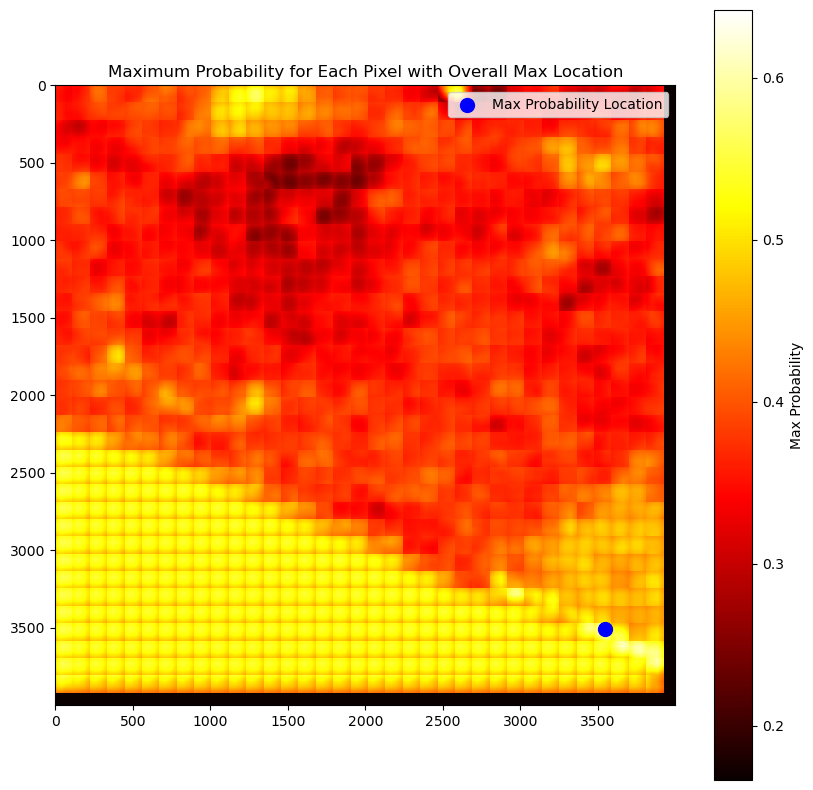

(0.6417247, (3509, 3546))

In [11]:
selected_prob_image = probability_map[0]
du.select_and_visualize_prob(selected_prob_image)

In [12]:
#for all the images, finding the percentage that are low probability pixels 
du.print_low_prob(probability_map)

Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%
Percentage of Pixels with Probability < 0.2: 3.96%


In [13]:
#modify the species maps to remove the low probability pixels
species_predictions = du.apply_modification(probability_map, species_pred)

In [14]:
#delete old species map for memory management
del species_pred

In [15]:
#make the new species map into a numpy array
species_predictions = np.array(species_predictions)

In [16]:
#take the argmax of the species predictions to get the final species map
species_predictions = np.argmax(species_predictions, axis=1)

In [17]:
#make the distance map a numpy array and delete the old distance map for memory management
distance_predictions = np.array(distance_pred)
distance_predictions = np.squeeze(distance_predictions, axis=1)
del distance_pred

In [18]:
#make ground truth species map a numpy array and delete the old species map for memory management
targets = np.array(species_true)
del species_true

In [19]:
#make the ground truth distance map a numpy array and delete the old distance map for memory management
distance_targets = np.array(distances_true)
del distances_true

In [20]:
print(f"targets shape: {targets.shape}")
print(f"distance_maps shape: {distance_targets.shape}")
print(f"species_maps_pred shape: {species_predictions.shape}")
print(f"distance_maps_pred shape: {distance_predictions.shape}")

targets shape: (16, 4000, 4000)
distance_maps shape: (16, 4000, 4000)
species_maps_pred shape: (16, 4000, 4000)
distance_maps_pred shape: (16, 4000, 4000)


## Visualize one from Each Category 

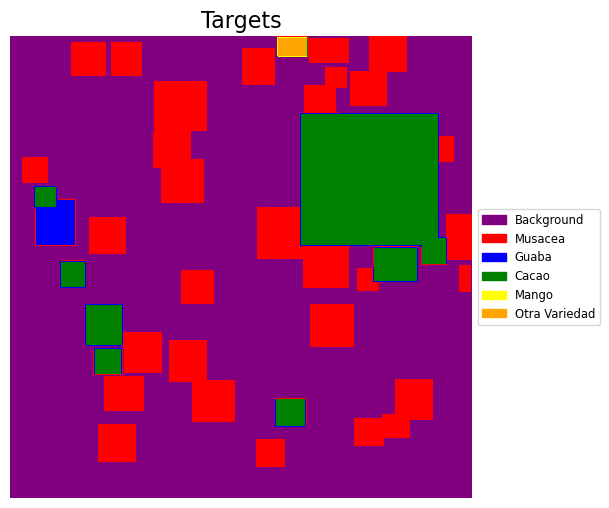

In [21]:
du.show_image_with_legend(image=targets[6], title='Targets', cmap=cmap, norm=norm, legend_info=legend_info)

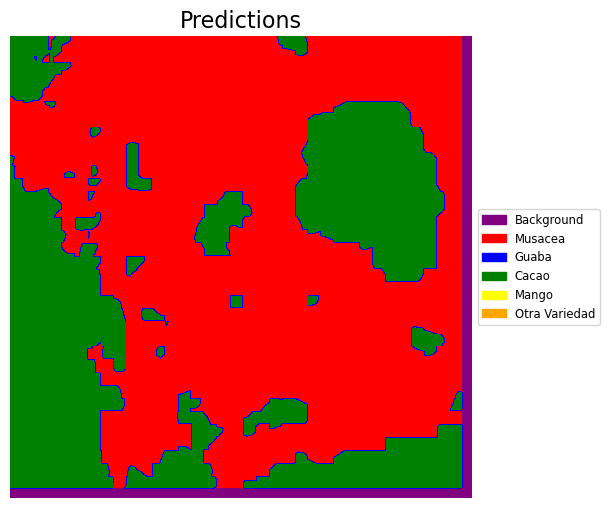

In [22]:
du.show_image_with_legend(image=species_predictions[6], title='Predictions', cmap=cmap, norm=norm, legend_info=legend_info)

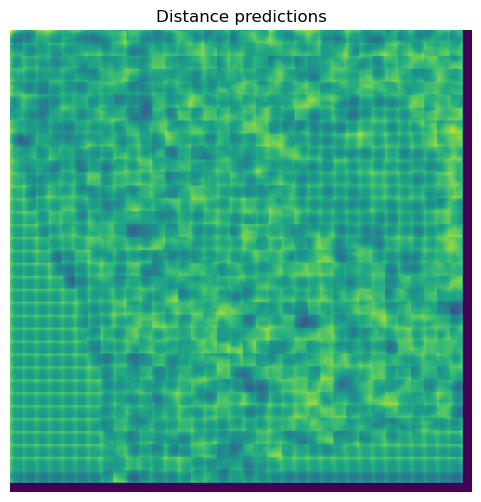

In [23]:
du.visualize_step(distance_predictions[6], "Distance predictions", cmap='viridis')

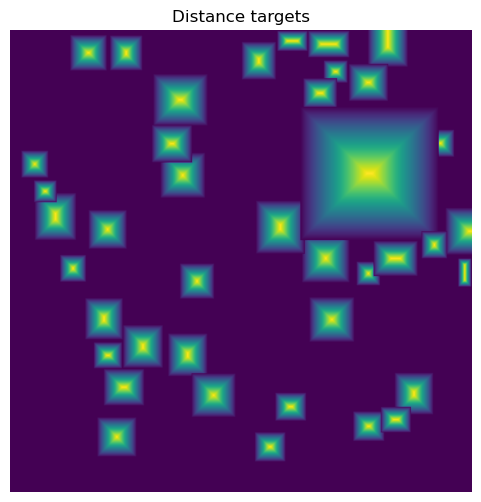

In [24]:
du.visualize_step(distance_targets[6], "Distance targets", cmap='viridis')

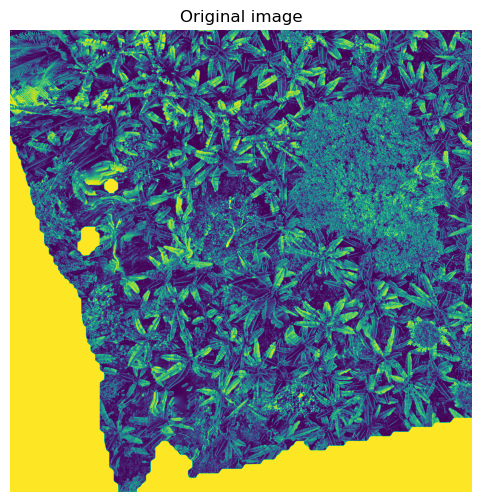

In [25]:
du.visualize_step(original_images[6][2], "Original image", cmap='viridis')

______

## Bringing in DeepForest Bounding Boxes

In [27]:
deepforest_results = pd.read_csv('iou_results_deepforest.csv')
deepforest_results_grouped = deepforest_results.groupby('image_path')

In [29]:
binary_deepforest = du.create_binary_deepforest(deepforest_results_grouped, root_dir, show = False)

### Combining DeepForest Results with Species Results

In [30]:
results, results_normalized = du.process_images(deepforest_results_grouped, species_predictions)

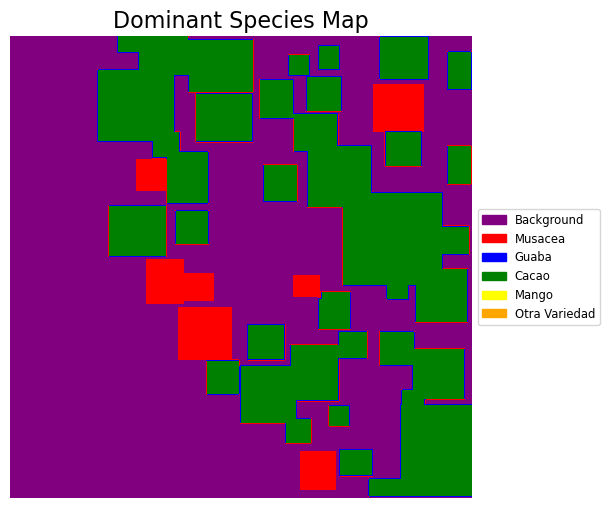

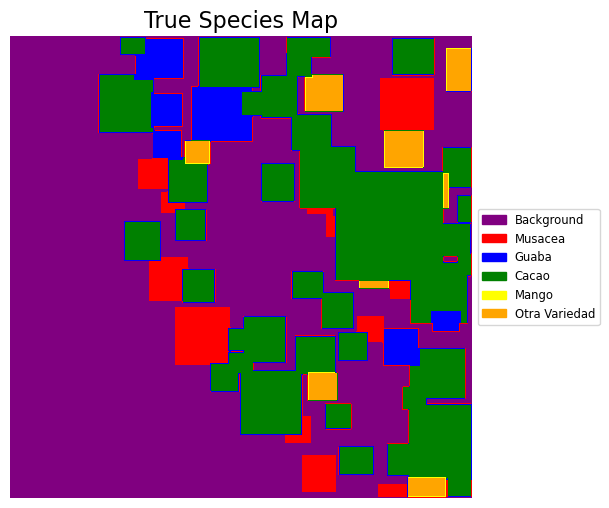

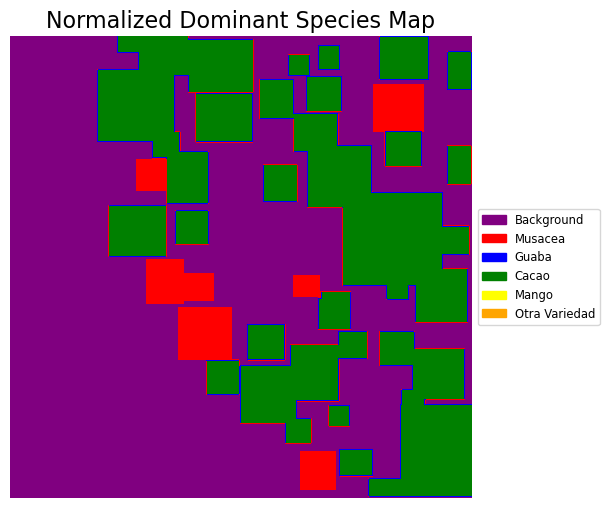

In [31]:
du.show_image_with_legend(results[8], title='Dominant Species Map', cmap=cmap, norm=norm, legend_info=legend_info)
du.show_image_with_legend(targets[8], title='True Species Map', cmap=cmap, norm=norm, legend_info=legend_info)
du.show_image_with_legend(results_normalized[8], title='Normalized Dominant Species Map', cmap=cmap, norm=norm, legend_info=legend_info)

In [32]:
#calculate new f1 scores 
du.calculate_average_f1(targets, results_normalized)

0.9883383092361137
0.9925637243223779
0.9945830981067029
0.9231521500786027
0.910471526735171
0.7559916685501021
0.8659645187090886
0.8523564821546133
0.7864252233907021
0.6046039941788302
0.7861604713811196
0.828205579449295
0.7610448794409855
0.841419040441968
0.9199204880745772
0.8388598292193807
Average F1 Score: 0.853128811466852


0.853128811466852

### Put these results in df form as well 

In [77]:
#test dataframe
df = pd.read_csv('csv_files/test_data_SEDD.csv')

In [78]:
df = du.change_column_names(df)

In [79]:
selected_columns = ['true_box_xmin', 'true_box_xmax', 'true_box_ymin', 'true_box_ymax', 'image_path', 'name', 'AGB', 'carbon', 'updated diameter']
df_original_selected = df[selected_columns]
#change updated diameter to diameter
df_original_selected = df_original_selected.rename(columns={'updated diameter': 'diameter'})

In [80]:
merged_df = pd.merge(df_original_selected, deepforest_results, on=['true_box_xmin', 'true_box_ymin', 'true_box_xmax', 'true_box_ymax', 'image_path'])
grouped_merged = merged_df.groupby('image_path')

In [81]:
processed_df = du.species_and_deepforest_df(species_predictions, grouped_merged)


In [82]:
processed_df = du.change_column_names_back(processed_df)

______

## Calculate Carbon Sequestration Potential

In [84]:
#prepare data using diameter_model specifications 
df_bbox = mu.add_bbox_columns(processed_df)

In [85]:
group = df_bbox.groupby('img_path')
first_group = group.get_group('Carlos Vera Arteaga RGB_7_3800_11053_7800_15053.png')
first_group

,xmin,ymin,xmax,ymax,img_path,name,AGB,carbon,diameter,pred_box_xmin,pred_box_ymin,pred_box_xmax,pred_box_ymax,iou,predicted_species,bbox_area,bbox_diagonal,bbox_across
0,1026.343384,14.278225,1645.476196,353.427582,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Cacao,7.338873,2.862161,7.957729,1080,5,1643,318,0.794580,Cacao,209978.494995,705.937480,619.132812
1,1219.373169,2376.889404,1409.002075,2567.502930,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Cacao,7.338873,2.862161,7.957729,1230,2404,1415,2575,0.759925,Cacao,36145.834404,268.872904,190.613526
2,919.469971,1128.330933,1092.855713,1298.221558,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Cacao,7.338873,2.862161,7.957729,920,1127,1097,1290,0.920402,Cacao,29456.612125,242.745628,173.385742
3,780.275696,242.771759,957.486023,421.889069,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Cacao,7.338873,2.862161,7.957729,752,204,965,425,0.674302,Cacao,31741.437023,251.965296,179.117310
4,1220.263062,1941.992798,1395.337036,2116.220215,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Cacao,7.338873,2.862161,7.957729,1213,1945,1397,2112,0.913858,Cacao,30502.686274,246.994108,175.073974
5,2863.862061,1900.471191,3040.162354,2085.149414,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Cacao,7.338873,2.862161,7.957729,2886,1918,3045,2077,0.735472,Cacao,32558.824826,255.319093,184.678223
6,1029.343384,17.278225,1643.476196,351.427582,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Cacao,7.338873,2.862161,7.957729,1080,5,1643,318,0.798145,Cacao,205212.084150,699.152990,614.132812
7,1222.373169,2379.889404,1407.002075,2565.502930,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Cacao,7.338873,2.862161,7.957729,1230,2404,1415,2575,0.766015,Cacao,34269.622244,261.801860,185.613526
8,922.469971,1131.330933,1090.855713,1296.221558,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Guaba,9.620841,3.752128,6.207028,920,1127,1097,1290,0.893607,Cacao,27765.230289,235.674938,168.385742
9,783.275696,245.771759,955.486023,419.889069,Carlos Vera Arteaga RGB_7_3800_11053_7800_1505...,Cacao,7.338873,2.862161,7.957729,752,204,965,425,0.636985,Cacao,29984.798840,244.894333,174.117310


In [86]:
df_prepared = mu.prepare_data(df_bbox, 'diameter')

In [88]:
X, y = mu.split_data(df_prepared, scaler = True)

In [89]:
#load in the diameter model
xg_model = joblib.load('models/diameter_model.pkl')

In [90]:
y_pred = xg_model.predict(X)

In [91]:
#check the mse on real world data
mu.mse_and_rmse(y, y_pred)

Mean Squared Error: 7.102240532532562
Root Mean Squared Error: 2.665002914169619


(7.102240532532562, 2.665002914169619)

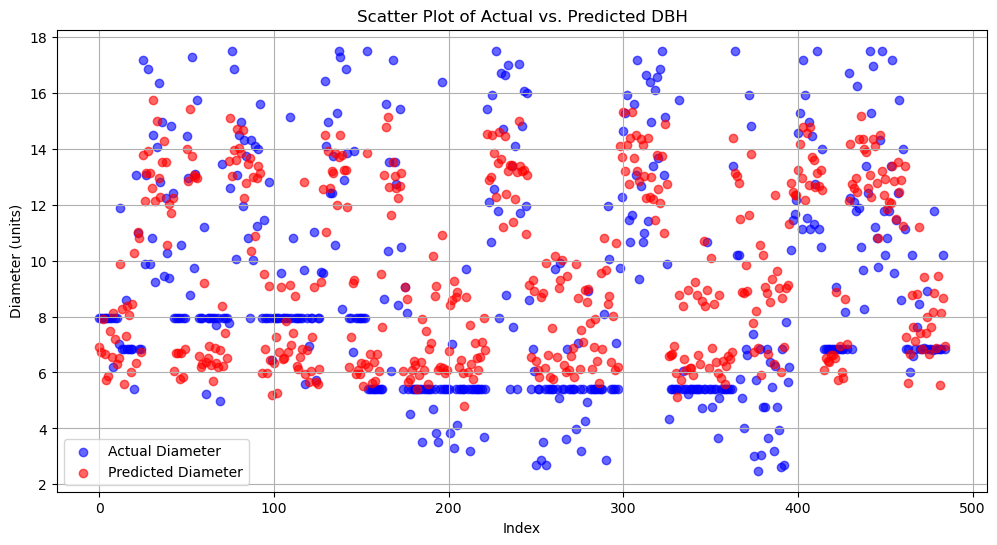

In [92]:
#look at the plot of predicted diameters 
mu.plot_results(y, y_pred)

In [93]:
mu.compare(y, y_pred)

    Actual Diameter  Predicted Diameter  Difference (Absolute)
0          7.957729            6.923347               1.034381
1          7.957729            6.719669               1.238060
2          7.957729            7.908500               0.049229
3          7.957729            6.666125               1.291603
4          7.957729            5.715807               2.241922
5          7.957729            5.859344               2.098385
6          7.957729            7.477889               0.479840
7          7.957729            6.536374               1.421355
8          6.207028            8.129634               1.922606
9          7.957729            7.193674               0.764055
10         7.957729            6.305652               1.652076
11         7.002801            6.518549               0.484252
12        11.872931            9.886172               1.986759
13         6.843647            8.281116               1.437469
14         6.843647            5.590661               1

### Diameters have been calcualted; now we can use these to calculate AGB

In [94]:
#prepare the processed_df like we did the model 
processed_df = mu.prepare_data(processed_df, 'diameter', one_hot_encode=False)
#add the predicted diameters to the processed_df
processed_df['predicted_diameter'] = y_pred

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_8822/1847496685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['predicted_diameter'] = y_pred


In [95]:
#calculate AGB based on the predicted diameters
processed_df['predicted_AGB'] = processed_df.apply(lambda row: du.calculate_AGB(row['predicted_diameter'], row['predicted_species']), axis=1)

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_8822/3458300639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['predicted_AGB'] = processed_df.apply(lambda row: du.calculate_AGB(row['predicted_diameter'], row['predicted_species']), axis=1)


In [96]:
#add a column for the difference 
processed_df['AGB_difference'] = abs(processed_df['AGB'] - processed_df['predicted_AGB'])

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_8822/2159281722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['AGB_difference'] = abs(processed_df['AGB'] - processed_df['predicted_AGB'])


### Comparison Metrics

In [99]:
#I will be comparing both the dataframes with species that don't match and with species that do

processed_df_species = processed_df[processed_df['predicted_species'] == processed_df['name']]


#### MSE and RMSE

In [100]:
#first let's look at the mse 
mu.mse_and_rmse(processed_df['AGB'], processed_df['predicted_AGB'])

Mean Squared Error: 125.07525334424649
Root Mean Squared Error: 11.183704812996742


(125.07525334424649, 11.183704812996742)

In [101]:
mu.mse_and_rmse(processed_df_species['AGB'], processed_df_species['predicted_AGB'])

Mean Squared Error: 7.713482879172872
Root Mean Squared Error: 2.777315768718579


(7.713482879172872, 2.777315768718579)

#### Averages

In [102]:
du.calculate_AGB_averages(processed_df, processed_df_species)

Including all species
Real AGB Average: 8.684586618573196
Predicted AGB Average: 5.925125149380025
AGB Difference Average: 4.7913500080491715
 
Excluding species that don't match their predicted species
Real AGB Average: 6.039284967978723
Predicted AGB Average: 5.86285451956903
AGB Difference Average: 2.267016007411713


In [103]:
du.averages_by_image(processed_df, processed_df_species)

Including all species
img_path
Carlos Vera Arteaga RGB_7_3800_11053_7800_15053.png      3.274797
Carlos Vera Guevara RGB_10_7600_7600_11600_11600.png     9.806558
Carlos Vera Guevara RGB_11_7600_8305_11600_12305.png    17.269911
Flora Pluas RGB_14_7600_11578_11600_15578.png            2.904644
Flora Pluas RGB_15_11400_0_15400_4000.png                6.945159
Flora Pluas RGB_16_11400_3800_15400_7800.png             9.118575
Flora Pluas RGB_9_3800_11578_7800_15578.png              5.340624
Leonor Aspiazu RGB_14_11400_7600_15400_11600.png         0.906065
Leonor Aspiazu RGB_2_0_7600_4000_11600.png               4.200754
Leonor Aspiazu RGB_6_3800_7600_7800_11600.png            3.806368
Leonor Aspiazu RGB_9_7600_3800_11600_7800.png            3.397135
Manuel Macias RGB_5_3800_6879_7800_10879.png             3.054747
Manuel Macias RGB_8_7600_6879_11600_10879.png            3.580664
Manuel Macias RGB_9_9748_0_13748_4000.png                3.837971
Nestor Macias RGB_11_7600_9024_11600_13024.pn

#### Sums

In [104]:
du.sum_tables(processed_df, processed_df_species)

Including all species
                                                           AGB  predicted_AGB
img_path                                                                     
Carlos Vera Arteaga RGB_7_3800_11053_7800_15053...   96.238285      56.940718
Carlos Vera Guevara RGB_10_7600_7600_11600_1160...  103.249607      39.053695
Carlos Vera Guevara RGB_11_7600_8305_11600_1230...  136.464907      41.363062
Flora Pluas RGB_14_7600_11578_11600_15578.png       183.925244     155.740017
Flora Pluas RGB_15_11400_0_15400_4000.png           277.170621     141.914936
Flora Pluas RGB_16_11400_3800_15400_7800.png        723.385225     296.952699
Flora Pluas RGB_9_3800_11578_7800_15578.png         263.526281     156.570270
Leonor Aspiazu RGB_14_11400_7600_15400_11600.png     47.395779      53.539192
Leonor Aspiazu RGB_2_0_7600_4000_11600.png          385.440934     335.430665
Leonor Aspiazu RGB_6_3800_7600_7800_11600.png       537.160644     463.509203
Leonor Aspiazu RGB_9_7600_3800_11600_7800.

#### Carbon

In [105]:
carbon_table = du.carbon_tables(processed_df, processed_df_species).round(2)

In [106]:
carbon_table

Carbon AGB  \
                img_path                                                         
All Species     Carlos Vera Arteaga RGB_7_3800_11053_7800_15053...       58.71   
                Carlos Vera Guevara RGB_10_7600_7600_11600_1160...       62.98   
                Carlos Vera Guevara RGB_11_7600_8305_11600_1230...       83.24   
                Flora Pluas RGB_14_7600_11578_11600_15578.png           112.19   
                Flora Pluas RGB_15_11400_0_15400_4000.png               169.07   
                Flora Pluas RGB_16_11400_3800_15400_7800.png            441.26   
                Flora Pluas RGB_9_3800_11578_7800_15578.png             160.75   
                Leonor Aspiazu RGB_14_11400_7600_15400_11600.png         28.91   
                Leonor Aspiazu RGB_2_0_7600_4000_11600.png              235.12   
                Leonor Aspiazu RGB_6_3800_7600_7800_11600.png           327.67   
                Leonor Aspiazu RGB_9_7600_3800_11600_7800.png           287.51   
                Manuel Macias RGB_5_3800_6879_7800_10879.png             41.27   
                Manuel Macias RGB_8_7600_6879_11600_10879.png            77.36   
                Manuel Macias RGB_9_9748_0_13748_4000.png                21.73   
                Nestor Macias RGB_11_7600_9024_11600_13024.png          154.21   
                Nestor Macias RGB_8_7600_0_11600_4000.png               307.34   
Species Matched Carlos Vera Arteaga RGB_7_3800_11053_7800_15053...       44.77   
                Carlos Vera Guevara RGB_10_7600_7600_11600_1160...       16.60   
                Carlos Vera Guevara RGB_11_7600_8305_11600_1230...        6.64   
                Flora Pluas RGB_14_7600_11578_11600_15578.png           104.34   
                Flora Pluas RGB_15_11400_0_15400_4000.png                81.79   
                Flora Pluas RGB_16_11400_3800_15400_7800.png            155.69   
                Flora Pluas RGB_9_3800_11578_7800_15578.png              99.68   
                Leonor Aspiazu RGB_14_11400_7600_15400_11600.png         16.69   
                Leonor Aspiazu RGB_2_0_7600_4000_11600.png               85.40   
                Leonor Aspiazu RGB_6_3800_7600_7800_11600.png           134.21   
                Leonor Aspiazu RGB_9_7600_3800_11600_7800.png           168.70   
                Manuel Macias RGB_5_3800_6879_7800_10879.png             17.85   
                Manuel Macias RGB_8_7600_6879_11600_10879.png            16.29   
                Manuel Macias RGB_9_9748_0_13748_4000.png                 0.53   
                Nestor Macias RGB_11_7600_9024_11600_13024.png          109.80   
                Nestor Macias RGB_8_7600_0_11600_4000.png               153.05   

                                                                    Carbon Predicted  \
                img_path                                                               
All Species     Carlos Vera Arteaga RGB_7_3800_11053_7800_15053...             34.73   
                Carlos Vera Guevara RGB_10_7600_7600_11600_1160...             23.82   
                Carlos Vera Guevara RGB_11_7600_8305_11600_1230...             25.23   
                Flora Pluas RGB_14_7600_11578_11600_15578.png                  95.00   
                Flora Pluas RGB_15_11400_0_15400_4000.png                      86.57   
                Flora Pluas RGB_16_11400_3800_15400_7800.png                  181.14   
                Flora Pluas RGB_9_3800_11578_7800_15578.png                    95.51   
                Leonor Aspiazu RGB_14_11400_7600_15400_11600.png               32.66   
                Leonor Aspiazu RGB_2_0_7600_4000_11600.png                    204.61   
                Leonor Aspiazu RGB_6_3800_7600_7800_11600.png                 282.74   
                Leonor Aspiazu RGB_9_7600_3800_11600_7800.png                 223.98   
                Manuel Macias RGB_5_3800_6879_7800_10879.png                   41.32   
                Manuel Macias RGB_8_7600_6879_1

In [107]:
len(processed_df_species)/len(processed_df)

0.6783505154639176